In [1]:
import cv2
import matplotlib.pyplot as plt
from time import sleep
import numpy as np

def show_img(img, size=(15, 15)):
    plt.figure(figsize=size)
    
    if len(img.shape) == 2:
        plt.gray()
        plt.imshow(img)
    else:
        plt.imshow(img[:, :, ::-1])
    plt.show()
    
def play_video(video_path, f = lambda x: x, frames=-1, window_name='Video', fps=30, **kwargs):
    vidcap = cv2.VideoCapture(video_path)
    
    if vidcap.isOpened():
        length = vidcap.get(cv2.CAP_PROP_FRAME_COUNT) if frames == -1 else frames
        success,img = vidcap.read()

        old_frame, k, counter = img, -1, 0
        while success and counter != frames and k != ord('q'):
            old_frame = img
            cv2.imshow(window_name, f(img, **kwargs))

            sleep(1/fps)
            success, img = vidcap.read()
            k = cv2.waitKey(1)
            counter += 1

            pos = int(counter/length * 90)
            print('Playing video: ' + '[' + pos*'o' + '>' + ' '*(90 - pos) + ']', end='\r')

        cv2.destroyAllWindows()
        vidcap.release()
    else:
        print("Couldn't open the video!")
    
    return old_frame    

def get_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    

# Colored images as input
def whitefy(img, b_threshold=70, g_threshold=127, r_threshold=100, bright=20):
    B, G, R = cv2.split(img)
    
    _, B = cv2.threshold(B, b_threshold, 255, cv2.THRESH_BINARY)
    _, G = cv2.threshold(G, g_threshold, 255, cv2.THRESH_BINARY)
    _, R = cv2.threshold(R, r_threshold, 255, cv2.THRESH_BINARY)

    mask = cv2.bitwise_and(cv2.bitwise_and(B, G), R)
    
    bright = np.ones(img.shape, dtype=np.uint8) * bright
    bright = cv2.bitwise_and(bright, bright, mask=mask)
    
    return img + bright

def get_edges_with_diff(img, se_1=2, se_2=2, shape_idx=0, iterations_erode=1, iterations_dilate=1):
    shape = (cv2.MORPH_ELLIPSE, cv2.MORPH_CROSS, cv2.MORPH_RECT)
    se = cv2.getStructuringElement(shape[shape_idx%len(shape)], (se_1, se_2))
    
    img_prev = cv2.erode(img, se, iterations=iterations_erode)
    img = cv2.dilate(img, se, iterations=iterations_dilate)
    
    return img - img_prev

def erode(img, se_1=2, se_2=2, shape_idx=0, iterations=1):
    shape = (cv2.MORPH_ELLIPSE, cv2.MORPH_CROSS, cv2.MORPH_RECT)
    se = cv2.getStructuringElement(shape[shape_idx%len(shape)], (se_1, se_2))

    return cv2.erode(img, se, iterations=iterations)

def dilate(img, se_1=2, se_2=2, shape_idx=0, iterations=1):
    shape = (cv2.MORPH_ELLIPSE, cv2.MORPH_CROSS, cv2.MORPH_RECT)
    se = cv2.getStructuringElement(shape[shape_idx%len(shape)], (se_1, se_2))

    return cv2.dilate(img, se, iterations=iterations)
    
def calibrate(img, f, args, range_min=0, range_max=255, title='calibrating'):
    cv2.imshow(title, img)
    
    for arg in args:
        cv2.createTrackbar(arg, title, range_min, range_max, lambda x : x)
        
    new_img, k = img, -1
    while k != ord('q'):
        cv2.imshow(title, new_img)
        new_kwargs = {k: v for k,v in ((arg, cv2.getTrackbarPos(arg, title)) for arg in args)}
        new_img = f(img, **new_kwargs)
        k = cv2.waitKey(1)
    cv2.destroyAllWindows()

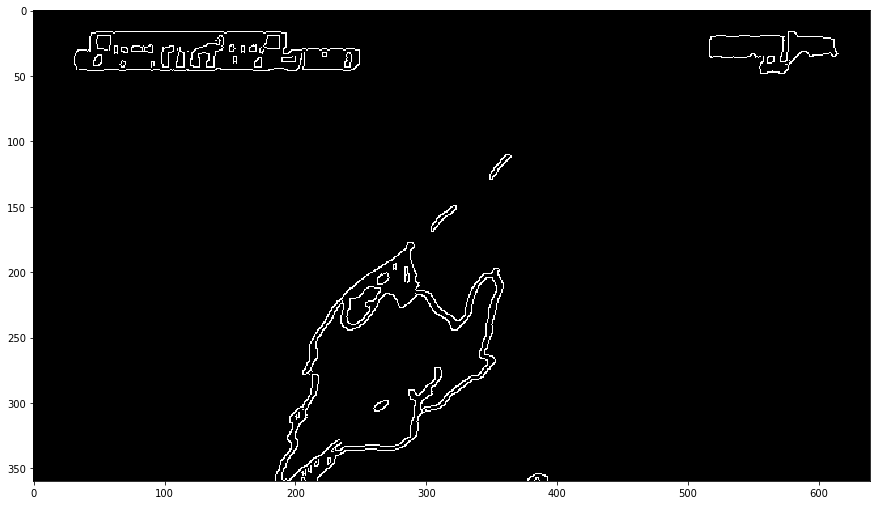

In [86]:
def treatment(img):
    img = whitefy(img)
    img = get_gray(img)
    img = cv2.Canny(img, 100, 200, True)
    img = get_edges_with_diff(img)
    
    img = dilate(img, se_1=2, se_2=2, shape_idx=0, iterations=3)
    #img = cv2.blur(img, (4, 4))
    img = erode(img, shape_idx=0, se_1=1, se_2=2, iterations=3)
    img = cv2.Canny(img, 100, 200, True, apertureSize=7)
    
    return img


img_orig = img
img = play_video('../samples_offside/sample25.mp4', f=treatment, frames=-1)

show_img(treatment(img))

# lines = cv2.HoughLines(img, 1 ,np.pi/180, 200)
# for rho,theta in lines[0]:
#     a = np.cos(theta)
#     b = np.sin(theta)

#     x0 = a*rho
#     y0 = b*rho
#     x1 = int(x0 + 1000*(-b))
#     y1 = int(y0 + 1000*(a))
#     x2 = int(x0 - 1000*(-b))
#     y2 = int(y0 - 1000*(a))

#     cv2.line(img_orig,(x1,y1),(x2,y2),(0,0,255),2)
    
# show_img(img_orig)

# calibrate(img, whitefy, ('b_threshold', 'g_threshold', 'r_threshold'), title='whitefy')
# calibrate(img, cv2.Canny, ('threshold1', 'threshold2'), title='canny')
# calibrate(img, get_edges_with_diff, ('se_1', 'se_2', 'iterations_erode', 'iterations_dilate', 'shape_idx'), 2, 20, title='edges')